- Python Version : 3.11.9

In [1]:
# 패키지 설치 및 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import datetime

# 시계열 데이터 모델링 패키지 내 함수 임포트
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose

# 경고메세지를 필터링
from warnings import filterwarnings

# 시계열

In [2]:
data = pd.read_csv("dataset/prices.csv")

In [3]:
data.head(2)

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0


## 전처리

### 날짜 데이터

In [4]:
# 원래의 string type 날짜를 별도 column으로 백업해줍니다.
data["str_date"] = data["date"].copy()
# 날짜 타입 데이터 변환
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', infer_datetime_format=True) # infer_datetime_format : 날짜시간 포멧 추정해서 파싱해준다.

# 변환 전후의 데이터 타입과 첫 5개 값을 비교해봅니다.
print("원본 데이터")
print("데이터 타입: ", data['str_date'].dtype)
print(data['str_date'][:5])

print("\ndatetime 변환 후")
print("데이터 타입: ", data['date'].dtype)
print(data['date'][:5])

원본 데이터
데이터 타입:  object
0    2016-01-05 00:00:00
1    2016-01-06 00:00:00
2    2016-01-07 00:00:00
3    2016-01-08 00:00:00
4    2016-01-11 00:00:00
Name: str_date, dtype: object

datetime 변환 후
데이터 타입:  datetime64[ns]
0   2016-01-05
1   2016-01-06
2   2016-01-07
3   2016-01-08
4   2016-01-11
Name: date, dtype: datetime64[ns]


In [11]:
# datetime의 "일" 정보만 따로 가져오기.
data['date'].dt.day.head()

0     5
1     6
2     7
3     8
4    11
Name: date, dtype: int64

In [12]:
# datetime의 "요일" 정보만 따로 가져오기
data['date'].dt.dayofweek.head()

0    1
1    2
2    3
3    4
4    0
Name: date, dtype: int64

In [13]:
# python의 built-in library로 datetime object를 생성
dt_example = datetime(2016, 1, 7)

# 생성한 예시 날짜와 데이터의 date영역 크기비교
# 2016년 1월 7일보다 작은 날짜인 첫 3개 값만 True로 나타난다.
print((data["date"] <= dt_example).head())
data["date"].head()

0     True
1     True
2     True
3    False
4    False
Name: date, dtype: bool


0   2016-01-05
1   2016-01-06
2   2016-01-07
3   2016-01-08
4   2016-01-11
Name: date, dtype: datetime64[ns]

## 분석

In [15]:
# 주식회사 APPLE (symbol이 'AAPL')의 주식 데이터
apple = data[data['symbol'] == 'AAPL']
apple.head()

,date,symbol,open,close,low,high,volume,str_date
254,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0,2010-01-04
721,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0,2010-01-05
1189,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0,2010-01-06
1657,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0,2010-01-07
2125,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0,2010-01-08


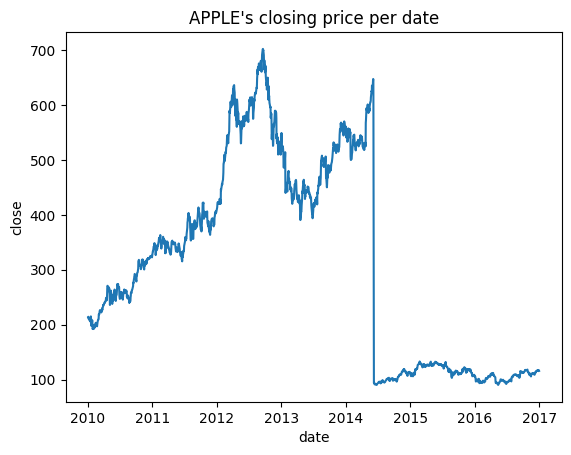

In [16]:
# APPLE의 일별 종가
ax = sns.lineplot(data=apple, x='date', y='close')
ax.set_title("APPLE's closing price per date")
plt.show()

원본 데이터 샘플수: 1762
액면분할 후 데이터 샘플수: 648


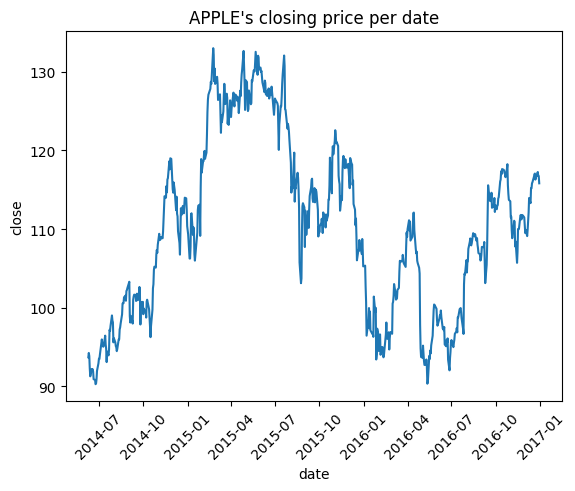

In [17]:
# 샘플수 비교
print(f"원본 데이터 샘플수: {len(apple)}")

# 액면분할 시점을 datetime object로 만들기
day_split = datetime(2014, 6, 9)

# "date"가 분할시점 이후인 데이터만 남기기
apple = apple[apple["date"] >= day_split]

print(f"액면분할 후 데이터 샘플수: {len(apple)}")

# 남은 데이터를 시각화
fig = sns.lineplot(data=apple, x='date', y='close')
fig.tick_params(axis='x', labelrotation=45)
fig.set_title("APPLE's closing price per date")
plt.show()

### 정상성 검정

In [18]:
# stationary test
dftest = adfuller(apple['close'])
# 결과값을 잘 보여주기 위한 함수
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

Test Statistic                  -2.156495
p-value                          0.222412
#Lags Used                       0.000000
Number of Observations Used    647.000000
Critical Value (1%)             -3.440498
Critical Value (5%)             -2.866017
Critical Value (10%)            -2.569154
dtype: float64


### 시계열데이터 분해

In [19]:
# 날짜 변수를 더 잘 시각화하기 위해 데이터 인덱스에 date 변수 넣기
apple.set_index('date', inplace=True)

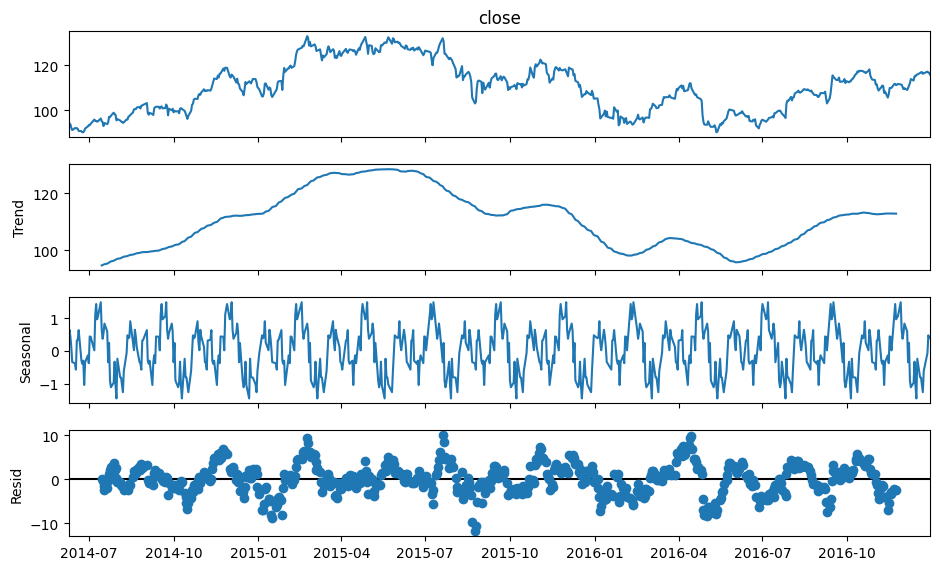

In [20]:
# 계절성 변동의 주기 값 설정
period = 50

# 시계열데이터의 계절성 분해 방법 적용
result = seasonal_decompose(apple['close'], model='addictive', period=period)

# 결과 시각화
fig = result.plot()
fig.set_size_inches((10, 6))
plt.show()

### 모델링

#### 이동평균

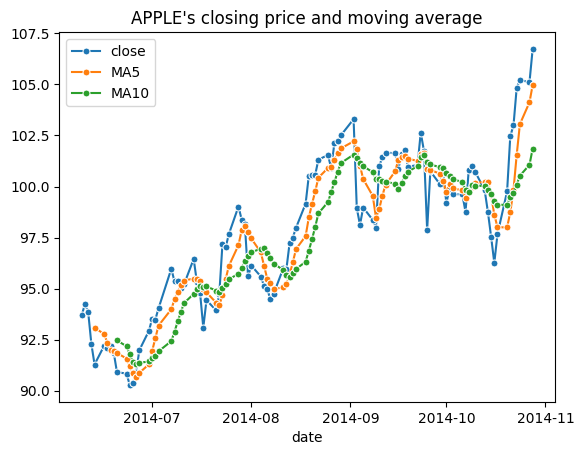

In [21]:
# 원본 데이터셋을 복사해 이동평균값을 추가로 저장할 데이터프레임을 생성
apple_with_MA = apple.copy()

# APPLE 주식 가격의 5일, 10일 이동평균을 계산해 별도 column으로 저장
apple_with_MA['MA5'] = apple['close'].rolling(5).mean()
apple_with_MA['MA10'] = apple['close'].rolling(10).mean()

# 처음 100개 값만 선택해 결과를 시각화.
ax = sns.lineplot(data=apple_with_MA[['close', 'MA5', 'MA10']][:100], dashes=False, markersize=5, marker='o')
ax.set_title("APPLE's closing price and moving average")
plt.show()

#### 자기회귀 모델링

In [22]:
# 자기 회귀 모델을 fitting
model = AutoReg(apple['close'], lags=5)
result = model.fit()

# 결과를 출력
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                  648
Model:                     AutoReg(5)   Log Likelihood               -1234.095
Method:               Conditional MLE   S.D. of innovations              1.649
Date:                Tue, 24 Dec 2024   AIC                           2482.191
Time:                        10:24:30   BIC                           2513.454
Sample:                             5   HQIC                          2494.323
                                  648                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4439      0.657      2.196      0.028       0.155       2.732
close.L1       1.0080      0.039     25.590      0.000       0.931       1.085
close.L2      -0.0523      0.056     -0.934      0.3

c:\ProgramData\anaconda3\envs\py3_11_9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
filterwarnings(action='ignore')  # python warnings를 무시하는 옵션

def plot_prediction(data, pred_start, pred_end, result):
    # 관측된 데이터의 샘플 수
    n_samples = len(data.index)

    # 예측할 날짜들 정의
    pred_dates = pd.date_range(start=pred_start, end=pred_end)
    pred_index = list(pred_dates)

    # 기존 관측된 날짜와 예측할 날짜에 대해 예측하기
    prediction = result.get_prediction(end=n_samples + len(pred_dates))

    # 예측값의 평균과 신뢰구간 계산
    pred_mean = prediction.predicted_mean[n_samples + 1:]
    pred_lower = prediction.conf_int()['lower'][n_samples + 1:]
    pred_upper = prediction.conf_int()['upper'][n_samples + 1:]

    # 시각화
    fig, ax = plt.subplots(figsize=(10,6))
    # 기존 관측된 시계열 데이터
    sns.lineplot(data=data)
    # 예측값과 신뢰구간 시각화
    ax.plot(pred_index, pred_mean, label='prediction', zorder=2)
    ax.fill_between(pred_index, pred_lower, pred_upper, color="gray", alpha=0.5, label='95% confidence interval', zorder=1)

    # 그림 설정
    ax.legend(loc='upper right')
    plt.title(f'Prediction from {pred_start} to {pred_end}')
    plt.show()

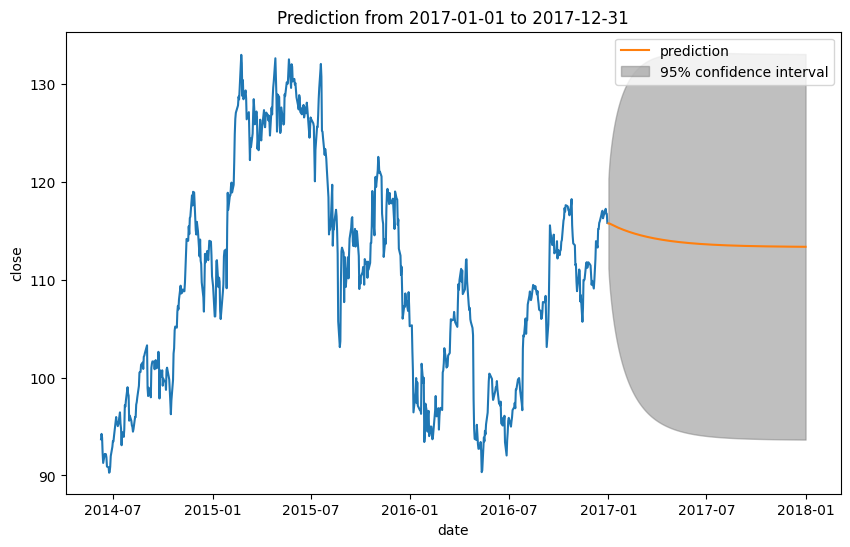

In [24]:
# 2017년에 대해서 예측하기
plot_prediction(data=apple['close'], pred_start='2017-01-01', pred_end='2017-12-31', result=result)